In [1]:
# Making imports convenient
import sys
import os
PATH=os.getcwd().split('/notebooks')[0]
sys.path.insert(1, PATH)

import torch
from torch.utils.data import DataLoader
from datasets import load_dataset, Dataset, concatenate_datasets
import transformers
from sklearn.model_selection import StratifiedKFold

from transformers import AutoTokenizer, DataCollatorWithPadding,AutoModelForSequenceClassification,TrainingArguments,Trainer

from src.utils.myutils import *
import yaml
from tqdm import tqdm
import logging
import json
import warnings
import random
import pandas as pd

logging.disable(logging.ERROR)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning) 

CS_DATA_PATH = PATH + '/data/CS/processed/'
CONFIG_PATH = PATH + '/src/utils/config.yaml'

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model_name = 'fav-kky/FERNET-C5'
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False,padding=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

BATCH_SIZE = 32

In [2]:
model_path = '/home/horyctom/bias-detection-thesis/src/models/trained/all_balanced.pth'

In [3]:
cw_hard = load_dataset('csv',data_files = CS_DATA_PATH + 'CW-HARD/cw-hard.csv')['train']
cwnc = load_dataset('csv',data_files = CS_DATA_PATH + 'CWNC/cwnc.csv')['train']
wikibias = load_dataset('csv',data_files = CS_DATA_PATH + 'WikiBias/wikibias.csv')['train']
basil = load_dataset('csv',data_files = CS_DATA_PATH + 'BASIL/basil.csv')['train']
nfnj = load_dataset('csv',data_files = CS_DATA_PATH + 'NFNJ/nfnj.csv')['train']
ua_crisis = load_dataset('csv',data_files = CS_DATA_PATH + 'UA-crisis/ua-crisis.csv')['train']
mpqa = load_dataset('csv',data_files = CS_DATA_PATH + 'MPQA/mpqa.csv')['train']
subj = load_dataset('csv',data_files = CS_DATA_PATH + 'SUBJ/subj.csv')['train']

In [4]:
all = concatenate_datasets([cw_hard,cwnc,wikibias,resample(basil),resample(nfnj),resample(ua_crisis),mpqa,subj]).shuffle(seed=42)

In [5]:
balanced = resample(all)

## Train

In [8]:
tokenized = preprocess_data(balanced,tokenizer,'sentence')
tokenized = tokenized.train_test_split(0.2)

In [9]:
pretraining_args = TrainingArguments(
    num_train_epochs=5,
    per_device_train_batch_size=BATCH_SIZE,  
    per_device_eval_batch_size=BATCH_SIZE,
    eval_steps=100,
    logging_steps=100,
    save_steps=400,
    disable_tqdm = False,
    warmup_steps=0,
    save_total_limit=1,
    evaluation_strategy="steps",
    weight_decay=0.1,
    output_dir = './',
    learning_rate=2e-5)

In [15]:
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2);
model.to(device)
trainer = Trainer(model,pretraining_args,train_dataset=tokenized['train'],data_collator=data_collator,
                  tokenizer=tokenizer,eval_dataset=tokenized['test'],compute_metrics=compute_metrics_eval)
trainer.train()

Step,Training Loss,Validation Loss,F1
100,0.647200,0.575273,0.704541
200,0.591500,0.543912,0.694739
300,0.557600,0.523798,0.732829
400,0.542600,0.529618,0.671850
500,0.515700,0.501054,0.749431
600,0.505900,0.489076,0.753680
700,0.496700,0.491014,0.771388
800,0.506900,0.496075,0.775773
900,0.477800,0.459874,0.774112
1000,0.488700,0.456026,0.756510


TrainOutput(global_step=3558, training_loss=0.4101996177900635, metrics={'train_runtime': 1287.7782, 'train_samples_per_second': 88.341, 'train_steps_per_second': 2.763, 'total_flos': 4410921176472480.0, 'train_loss': 0.4101996177900635, 'epoch': 3.0})

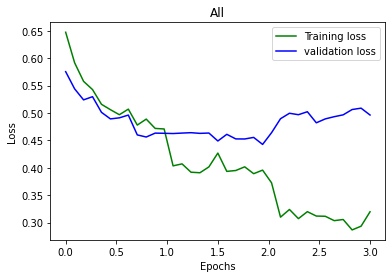

In [2]:
plot_losses(pd.read_csv('./logs/all.loss',sep='\t'),epochs=3.0,name='All')

## Train all

In [19]:
tokenized = preprocess_data(balanced,tokenizer,'sentence')

In [6]:
pretraining_args = TrainingArguments(
    num_train_epochs=2,
    per_device_train_batch_size=32,  
    logging_steps=300,
    save_steps=400,
    disable_tqdm = False,
    warmup_steps=0,
    save_total_limit=1,
    weight_decay=0.1,
    output_dir = './',
    learning_rate=2e-5)

In [24]:
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2);
model.to(device)
trainer = Trainer(model,pretraining_args,train_dataset=tokenized,data_collator=data_collator,
                  tokenizer=tokenizer)
trainer.train()

torch.save(model.state_dict(),model_path)

Step,Training Loss
300,0.599100
600,0.503200
900,0.483500
1200,0.484100
1500,0.456400
1800,0.390400
2100,0.392100
2400,0.379700
2700,0.375300
3000,0.363900
